Adding the following meta features allowed my model to go from 0,252 to 0.217. I suspect that more gain can be squeezed from similar features as well, I just found this last night. The magic features are based on question frequency. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import timeit

In [2]:
train_orig =  pd.read_csv('../input/train.csv', header=0)
test_orig =  pd.read_csv('../input/test.csv', header=0)

tic0=timeit.default_timer()
df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

In [3]:
corr_mat = train_comb.corr()
corr_mat.head()
#more frequenct questions are more likely to be duplicates

,id,q1_hash,q2_hash,q1_freq,q2_freq,is_duplicate
id,1.000000,0.692730,0.286969,-0.001608,-0.000777,-0.008784
q1_hash,0.692730,1.000000,0.492993,-0.341777,-0.202545,-0.206498
q2_hash,0.286969,0.492993,1.000000,-0.392605,-0.466434,-0.349626
q1_freq,-0.001608,-0.341777,-0.392605,1.000000,0.494315,0.296621
q2_freq,-0.000777,-0.202545,-0.466434,0.494315,1.000000,0.198609


In [9]:
train = train_comb
test = test_comb

In [14]:
test['test_id'] = test.id

In [7]:
features_to_save = [
    'q1_hash', 'q2_hash', 'q1_freq', 'q2_freq'
]

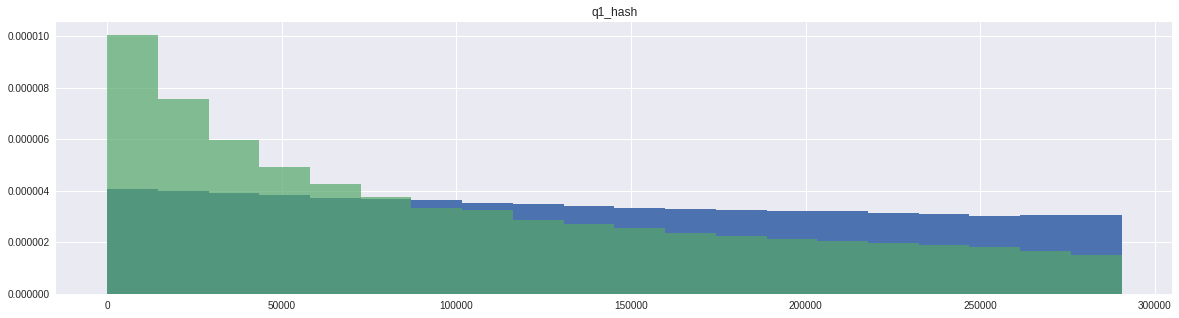

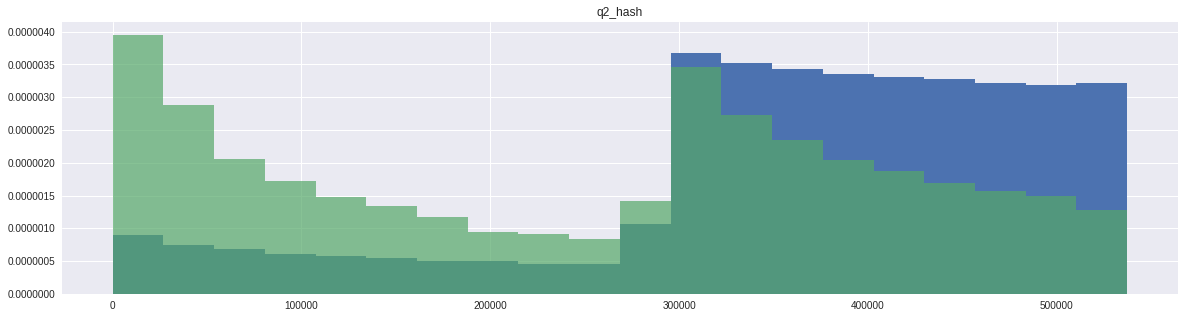

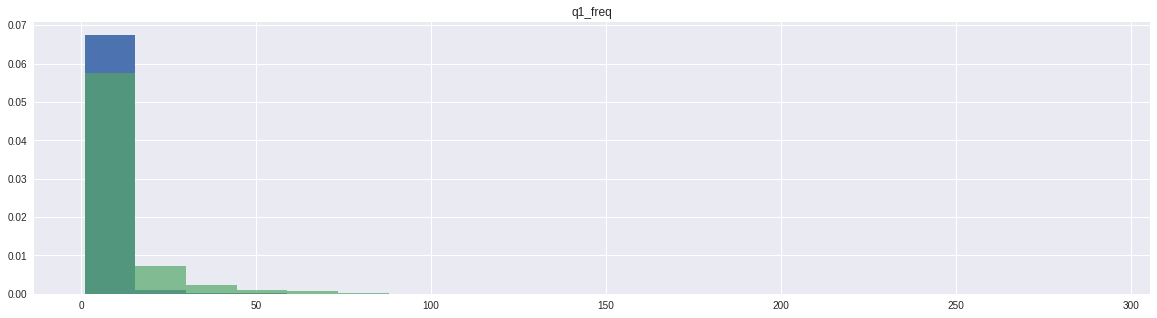

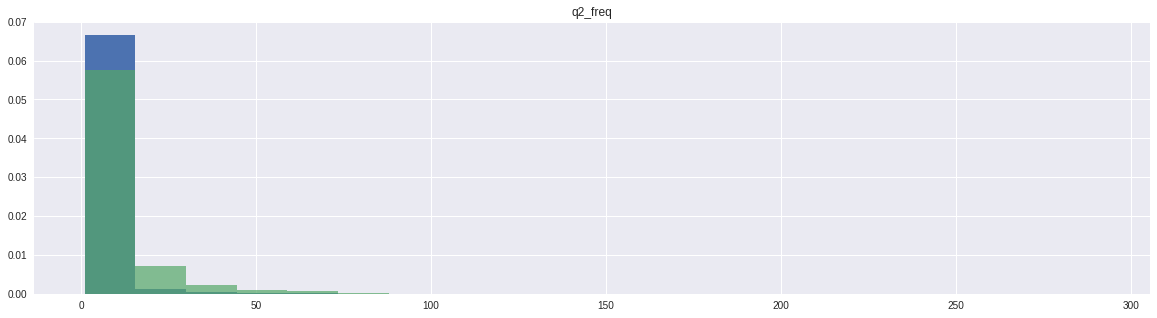

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 5.0)

for feature in features_to_save:
    plt.title(feature)
    plt.hist(train[feature][train['is_duplicate'] == 0], bins=20, normed=True, label='0')
    plt.hist(train[feature][train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
    plt.show()

In [15]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')